#### Import required layers and utils from the framework

In [14]:
import keras

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input, Lambda, BatchNormalization
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K


# from theano.sandbox.cuda.dnn import *

#### Import other required utils

In [15]:
from copy import deepcopy
import datetime
import dicom
from fnmatch import fnmatch
import h5py
import numpy as np
import os
from os import path, walk
import pickle
from PIL import Image, ImageDraw
import re
import time
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

%matplotlib inline
plt.set_cmap('gray')

#### sci-kit learn stuff

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [59]:
DICOM_PREFIX = "/home/a.kondyukov/data/Indianapolis_dicom/"
MASK_PREFIX  = "/home/a.kondyukov/data/Indianapolis_masks_new/"

BATCH_SIZE = 5
EPOCH_NUM = 300

IMAGE_SIZE = 512

STRUCTURE = "lung"
EXPERIMENT_NAME = "%s_segmentation_tb_lrn" % STRUCTURE
OUT_DIR = "/home/a.kondyukov/data/out/%s/" % EXPERIMENT_NAME
DO_LRN = True # LRN is Local Response Normalization (lateral inhibition)

MODEL_FILENAME = "%s_u-net_%s" % (EXPERIMENT_NAME, datetime.date.today().strftime("%d%b%Y"))

In [74]:
images = []
masks = []

for case in ["atherosclerosis", "calcinosis", "cardiomegaly_mild", "cardiomegaly_modsev", "tortuous_aorta"]:

    filenames = !ls /home/a.kondyukov/data/Indianapolis_masks_new/"$case"_masks/ | grep ".png$"
    for mask_filename in filenames:
        image_filename = re.sub(r"([0-9]+)(.*).png", DICOM_PREFIX + r"\1/\1\2", mask_filename)
        image = imresize(dicom.read_file(image_filename).pixel_array, [IMAGE_SIZE, IMAGE_SIZE])
        mask_filename = os.path.join(MASK_PREFIX, case+"_masks", mask_filename)
        mask = (imresize(plt.imread(mask_filename).mean(axis=2), [IMAGE_SIZE, IMAGE_SIZE]) > 0.5).astype(int)
        
        images.append(image)
        masks.append(mask)

In [75]:
images = np.array(images)
masks = np.array(masks)

#### This version of U-net uses zero-padding so as to leave image size unchanged

In [76]:
smooth = 1.

In [77]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [116]:
def get_unet():
    inputs = Input((1, IMAGE_SIZE, IMAGE_SIZE))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[dice_coef])

    return model

In [117]:
model = get_unet()
model.compile(optimizer='adam', loss='binary_crossentropy')

In [34]:
model.load_weights("../models/unet.hdf5")

In [99]:
train_indices, validate_indices = train_test_split(range(len(images)))

In [100]:
X = images
Y = masks

In [101]:
print(X.shape, Y.shape)
print(X.max(), Y.max())

(253, 512, 512) (253, 512, 512)
255 1


In [102]:
X_train, X_validate = images[train_indices, None, :, :], images[validate_indices, None, :, :]
Y_train, Y_validate = masks[train_indices, None, :, :], masks[validate_indices, None, :, :]

In [91]:
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
with open(OUT_DIR + "train_test_sep", "w+") as f:
    np.savez_compressed(OUT_DIR + "train_test_sep", train_indices=train_indices, validate_indices=validate_indices)

In [109]:
Y_train[0].max()

1

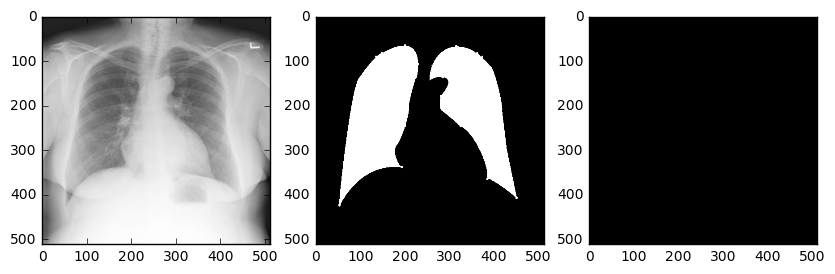

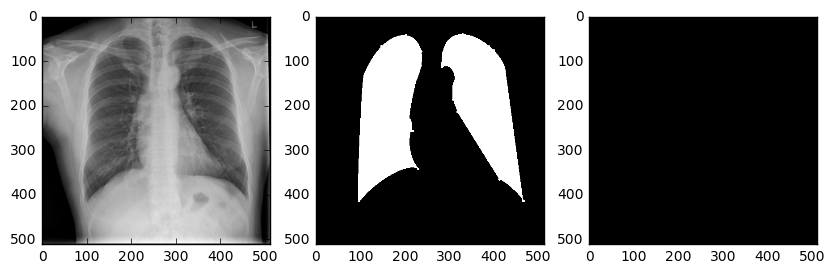

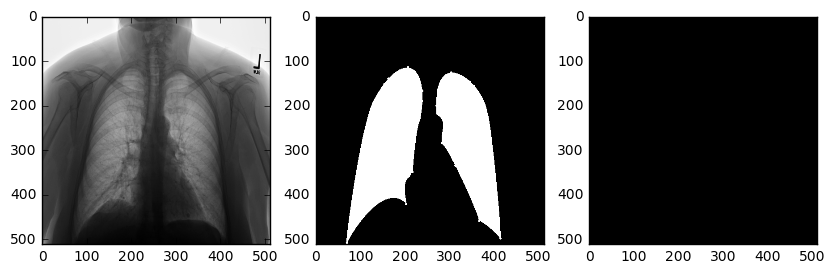

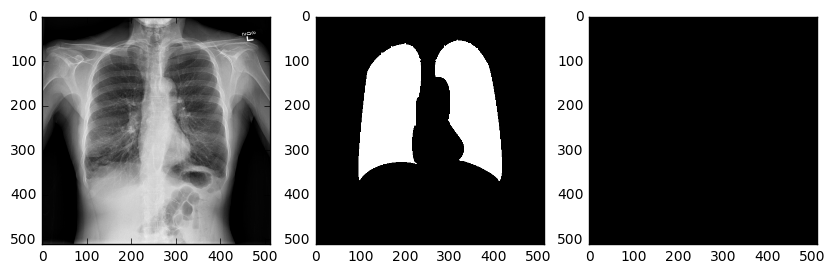

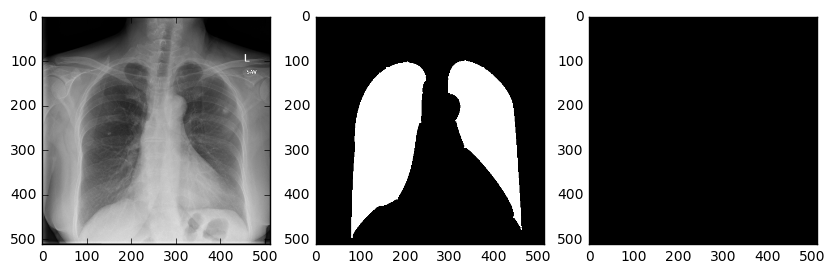

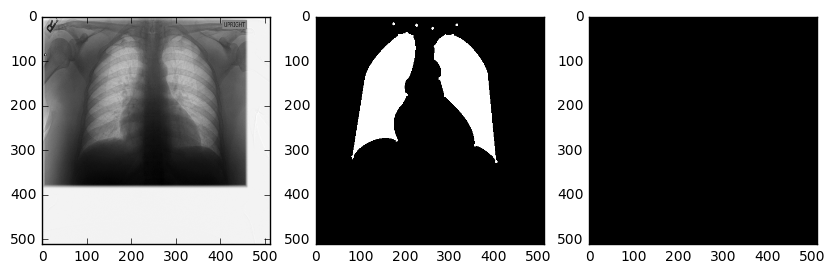

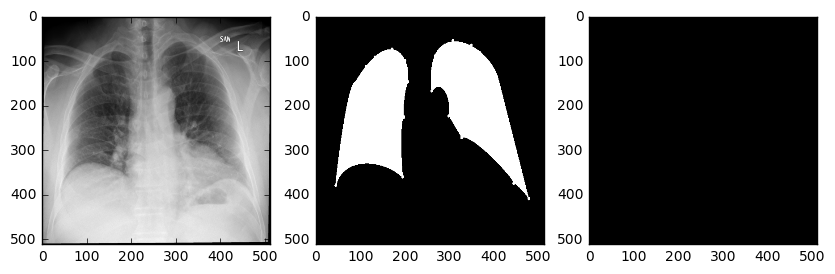

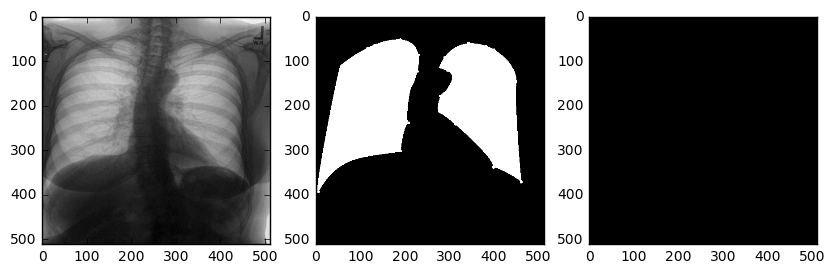

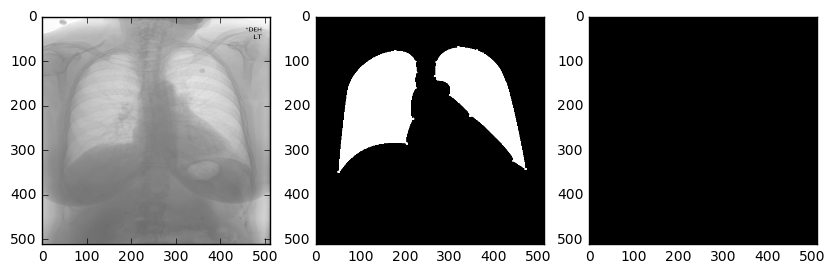

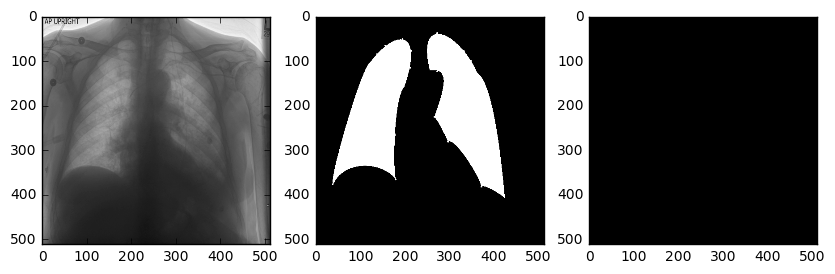

In [105]:
for i in range(10):
    plt.figure(i, figsize=(10, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(X_validate[i][0])
    plt.subplot(1, 3, 2)
    plt.imshow(Y_validate[i][0])
    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(np.array([X_validate[i]]))[0][0])

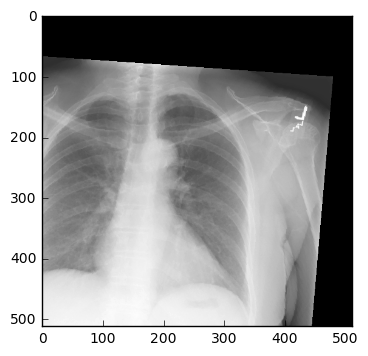

In [114]:
plt.imshow(X_batch[1][0])

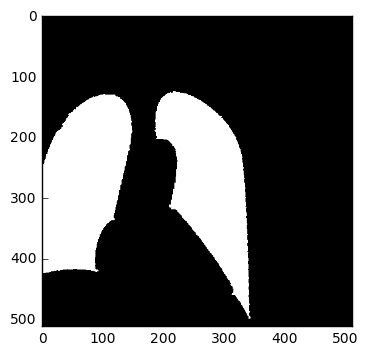

In [115]:
plt.imshow(Y_batch[1][0])

In [ ]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10.,
                    zoom_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    fill_mode='constant',
                    cval=0.,
                    horizontal_flip=True)

for ep in range(EPOCH_NUM):
    e = ep + 0
    print('Epoch', e)
    batches = 0
    
    X_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))
    Y_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))

    train_losses = []
    epoch_finished = False
    start = time.time()

    print("\r", "0%", end="")
    max_iter = X_train.shape[0] // BATCH_SIZE + (X_train.shape[0] % BATCH_SIZE != 0)
    
    for i, X_batch in enumerate(datagen.flow(np.concatenate([X_train, Y_train, np.zeros_like(X_train)], axis=1), 
                                batch_size=BATCH_SIZE)):
        print("\r", "%.2f" % (i / max_iter * 100) + "%", end="")
        Y_batch = np.expand_dims(X_batch[:, 1, :, :], 1)
        X_batch = np.expand_dims(X_batch[:, 0, :, :], 1)

        loss = model.train_on_batch(X_batch, Y_batch)
        train_losses.append(loss)
        batches += 1
        if batches >= len(X_train) / 5:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            validation_loss = model.evaluate(X_validate, Y_validate, verbose=0)
            print('train loss: ', np.mean(train_losses), 
                  'validation loss: ', validation_loss)
            break
                
#     if e % 50 == 0:
#         model.save_weights("./models/" + MODEL_FILENAME + '_' + str(e) + '.h5', overwrite=True)
    print('Time per epoch: ', time.time() - start)
        

# model.save_weights("./models/" + MODEL_FILENAME + '.h5', overwrite=True)

Epoch 0
 97.37%train loss:  0.851962 validation loss:  0.552795946598
Time per epoch:  133.4039146900177
Epoch 1
 97.37%train loss:  0.411264 validation loss:  0.508513614535
Time per epoch:  126.03426170349121
Epoch 2
 50.00%

In [ ]:
model.load_weights("models/lung_segmentation_indianapolis_lrn_u-net_04Nov2016_250.h5")

In [ ]:
for i in range(10):
    plt.figure(i, figsize=(12, 12))
    plt.imshow((model.predict(np.array([X_validate[i]]))[0][0] + 0.9) * X_validate[i][0])

In [ ]:
Y_pred = model.predict(X_validate)

In [ ]:
jaccard = \
    ((Y_pred > 0.5) & Y_validate.astype(np.bool)).mean() / ((Y_pred > 0.5) | Y_validate.astype(np.bool)).mean()

In [ ]:
jaccard

In [ ]:
Y_pred_train = model.predict(X_train)
Y_pred_validate = model.predict(X_validate)

for i, mask in enumerate(Y_pred_train):
    num = train_indices[i]
    
    if not os.path.exists(OUT_DIR + 'train'):
        os.makedirs(OUT_DIR + 'train')
        
    np.savez(OUT_DIR + "train/predictedMask_%03d.npz" % num, mask[0])
    np.savez(OUT_DIR + "train/originalImage_%03d.npz" % num, X[i][0])
    
    plt.imsave(OUT_DIR + "train/predictedMask_%03d.png" % num, mask[0])
    plt.imsave(OUT_DIR + "train/originalImage_%03d" % num, X[i][0])
    
for i, mask in enumerate(Y_pred_validate):
    num = validate_indices[i]
    
    if not os.path.exists(OUT_DIR + 'validate'):
        os.makedirs(OUT_DIR + 'validate')
    
    np.savez(OUT_DIR + "validate/predictedMask_%03d.npz" % num, mask[0])
    np.savez(OUT_DIR + "validate/originalImage_%03d.npz" % num, X[i][0])
    
    plt.imsave(OUT_DIR + "validate/predictedMask_%03d.png" % num, mask[0])
    plt.imsave(OUT_DIR + "validate/originalImage_%03d" % num, X[i][0])